# Spatial mapping of cell types in the slide-seq data

## Contents

* [Loading packages](#Loading_packages)
* [Reading single cell reference cell types and Slide-Seq V2 data from Stickels et al](#read)
* [Extract cell type reference signatures from the regression model output](#signatures)
* [Train cell2location model to spatially map cell types](#cell2location)


* [Fig 2H](#Fig2H)
* [Fig 2H Supplementary Inh neurones](#Fig2H_suppl)

* [Fig 3C slide seq supplementary](#Fig3C)

### Loading packages <a class="anchor" id="Loading_packages"></a>

In [1]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib

data_type = 'float32'

# this line forces theano to use the GPU and should go before importing cell2location
os.environ["THEANO_FLAGS"] = 'device=cuda0,floatX=' + data_type + ',force_device=True'

sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/')
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/cell2location_dev/')

import cell2location

from matplotlib import rcParams
import seaborn as sns
import pickle

# silence scanpy that prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/nfs/users/nfs_v/vk7/.local/lib/python3.7/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 7605 on context None
Mapped name None to device cuda0: Tesla V100-SXM2-32GB (0000:89:00.0)


### Reading single cell reference cell types and Slide-Seq V2 data from Stickels et al <a class="anchor" id="read"></a> 

In [2]:
sp_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/data/stickels_et_al_2020_slide_seqV2/'
results_folder2 = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/results/mouse_viseum_snrna/'
results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/stickels_et_al_2020_slide_seqV2/'

In [3]:
reg_mod_name = 'RegressionNBV2Torch_65covariates_40532cells_12819genes'
reg_path = f'{results_folder2}regression_model/{reg_mod_name}/'

adata_snrna_raw = sc.read(f'{reg_path}sc.h5ad')
r = pickle.load(file = open(f'{reg_path}model_.p', "rb"))
reg_mod = r['mod']

In [4]:
slideseq = anndata.read_h5ad(f'{sp_data_folder}stickels_et_al_2020_slide_seqV2.h5ad')

slideseq.var['SYMBOL'] = slideseq.var_names
# add x and y coordinates
slideseq.obsm['spatial'] = np.array([-slideseq.obs['xcoord'], slideseq.obs['ycoord']]).T

In [5]:
slideseq.uns['spatial'] = {k: None for k in slideseq.obs['filename'].unique()}

sc.pp.filter_genes(slideseq, min_cells=500)

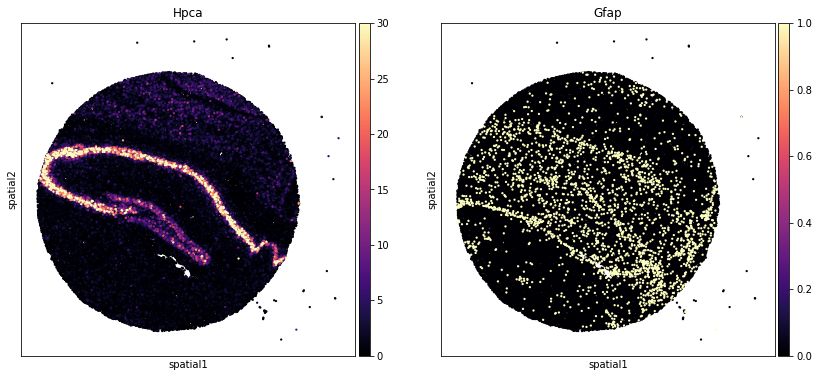

In [6]:
# just check that the sample 2 data is loaded correctly
with matplotlib.rc_context({"figure.figsize": (6, 6),
                            "axes.facecolor": "white"}):
    sc.pl.spatial(slideseq[slideseq.obs['batch'].isin(['2']), :], 
                  img_key=None, cmap='magma',
                  color=['Hpca', 'Gfap'], size=0.3,
                  vmin=0, vmax='p99.2',
                  gene_symbols='SYMBOL', ncols=2)

In [7]:
slideseq[slideseq.obs['batch'].isin(['2']), :].shape

(53208, 10302)

In [8]:
# put raw untransformed counts into the raw slot
slideseq.raw = slideseq

### Extract cell type reference signatures from the regression model output <a class="anchor" id="signatures"></a> 

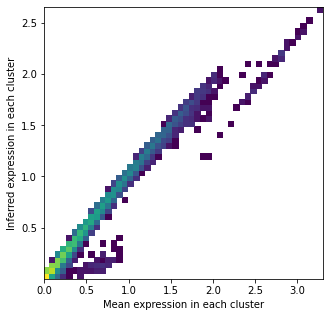

In [9]:
# export inferred averages in each cluster
inf_aver = adata_snrna_raw.var.copy()
inf_aver = inf_aver.loc[:, [f'mean_cov_effect_annotation_1_{i}' for i in adata_snrna_raw.obs['annotation_1'].unique()]]
from re import sub
inf_aver.columns = [sub(f'mean_cov_effect_annotation_1_{i}', '', i) for i in adata_snrna_raw.obs['annotation_1'].unique()]
inf_aver = inf_aver.iloc[:, inf_aver.columns.argsort()]

adata_snrna_raw_copy = adata_snrna_raw.copy()
adata_snrna_raw_copy.var_names = adata_snrna_raw_copy.var['SYMBOL'].astype(str)
adata_snrna_raw_copy.var_names_make_unique()
adata_snrna_raw.var['SYMBOL'] = adata_snrna_raw_copy.var_names
inf_aver.index = adata_snrna_raw.var.loc[inf_aver.index, 'SYMBOL']

# scale up by average sample scaling factor
inf_aver = inf_aver * adata_snrna_raw.uns['regression_mod']['post_sample_means']['sample_scaling'].mean()


# compute mean expression of each gene in each cluster
aver = cell2location.cluster_averages.cluster_averages.get_cluster_averages(adata_snrna_raw, 'annotation_1')
aver = aver.loc[adata_snrna_raw.var_names,:]

# export inferred averages in each cluster
#inf_aver = reg_mod.covariate_effects.copy()
#from re import sub
#inf_aver.columns = [sub('mean_cov_effect_Subset_', '', i) for i in inf_aver.columns]
#inf_aver = inf_aver.loc[aver.index, aver.columns]

rcParams['figure.figsize'] = 5, 5
plt.hist2d(np.log10(aver.values.flatten()+1), np.log10(inf_aver.values.flatten()+1),
           bins=50, norm=matplotlib.colors.LogNorm());
plt.xlabel('Mean expression in each cluster');
plt.ylabel('Inferred expression in each cluster');

### Train cell2location model to spatially map cell types <a class="anchor" id="cell2location"></a> 

In [18]:
sc.settings.set_figure_params(dpi = 100, color_map = 'RdPu', dpi_save = 100,
                              vector_friendly = True, format = 'pdf',
                              facecolor='white')

r = cell2location.run_cell2location(
                      sc_data=inf_aver, 
                      sp_data=slideseq[slideseq.obs['batch'].isin(['2']), :],
                      model_name='CoLocationModelNB4V2',
                      verbose=True, return_all=False,
                      
                      summ_sc_data_args={'cluster_col': "annotation_1"},
                                      
                      train_args={'use_raw': True,
                                  'n_iter': 30000, 'learning_rate': 0.005,
                                  'sample_prior': False, # set to false for large spatial data 
                                  'readable_var_name_col': "SYMBOL",
                                  'sample_name_col': 'batch'},
                                      
                      posterior_args={'n_samples': 1000},
                                      
                      export_args={'path': results_folder + 'our_ref/', 
                                   'run_name_suffix': '',
                                   'save_model': False, 'img_key': None, 'scanpy_plot_size': 0.4,
                                   'scanpy_plot_vmax': 'p99.7',
                                   'scanpy_coords_name': 'spatial', 'export_q05': True},
    
                      model_kwargs={ # Prior on the number of cells, cell types and co-located combinations
          
                    'cell_number_prior': {
                        # Use visual inspection of the tissue image to determine 
                        # the average number of cells per spot,
                        # an approximate count is good enough:
                        'cells_per_spot': 1, 
                        # Prior on the number of cell types (or factors) in each spot
                        'factors_per_spot': 1, 
                        # Prior on the number of correlated cell type combinations in each spot
                        'combs_per_spot': 1
                    },
                    'cell_number_var_prior':{'cells_mean_var_ratio': 1, 'combs_mean_var_ratio': 2.5, 
                                             'factors_mean_var_ratio': 2.5},
          
          
                     # Prior on change in sensitivity between technologies
                    'gene_level_prior':{
                        # Prior on average change in expression level from scRNA-seq to spatial technology,
                        # this reflects your belief about the sensitivity of the technology in you experiment
                        'mean': 1/10, 
                        # Prior on how much individual genes differ from that average,
                        # a good choice of this value should be lower that the mean
                        'sd': 1/20
                    },
                          
                     # The number of co-located cell type combinations
                    'n_comb': 50, 'spot_fact_mean_var_ratio': 5
      }
)

### Summarising single cell clusters ###
### Creating model ### - time 0.12 min
### Analysis name: CoLocationModelNB4V2_59clusters_53208locations_9069genes
### Training model ###


Finished [100%]: Average Loss = 7.594e+07


Finished [100%]: Average Loss = 7.594e+07



### Sampling posterior ### - time 358.38 min



### Saving results ###
### Ploting results ###
### Plotting posterior of W / cell locations ###
Consider running `set_figure_params(dpi_save=...)`, which will adjust `matplotlib.rcParams['savefig.dpi']`
### Done ### - time 382.8 min


Cell locations are added to `sp_data` as columns of `sp_data.obs` and the estimates of all parameters of the model are exported to `sp_data.uns['mod']`. This anndata object and 4 csv files `W.csv` / `W_q05.csv` with cell locations are  saved to the results directory:

- sp.h5ad - Anndata object with all results and spatial data.   
- W_cell_density.csv - density of each cell type regulatory programme, mean of the posterior distribution.   
- W_cell_density_q05.csv - density of each cell type regulatory programme, 5% quantile of the posterior distribution representing confident cell density level.   
- W_mRNA_count.csv - mean of the posterior distribution representing the number of mRNA molecules assigned to each cell type.   
- W_mRNA_count_q05.csv - 5% quantile of the posterior distribution, representing the number of mRNA molecules confidently assigned to each cell type.   

The same quantities are also plotted for each regulatory programme (save to `r['run_name']/plots/scanpy`, on black background and overlayed on the histology image paired with each sample (`histo_` prefix).


The downstream analysis notebook adds more results to:
- sp_with_clusters.h5ad

When `'save_model': True`, the trained model `r['mod']` is also saved as a pickle file. You can load the model later and continue training. 

In [10]:
r = {'run_name': 'CoLocationModelNB4V2_59clusters_53208locations_9069genes'}

The results are saved to:  

In [11]:
results_folder + r['run_name']

'/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/stickels_et_al_2020_slide_seqV2/CoLocationModelNB4V2_59clusters_53208locations_9069genes'

#### Evaluating training

Now we need to check if our model has trained successfully by examining a few diagnosic plots. 

First, we look at the ELBO loss / cost function over training iterations. This plot omits the first 20% of training iterations during which loss changes by orders of magnitude. Here we see that the model converged by the end of training, some noise in the ELBO loss function is acceptable. If there are large changes during the last few thousands of iterations we recommend increasing the `'n_iter'` parameter.

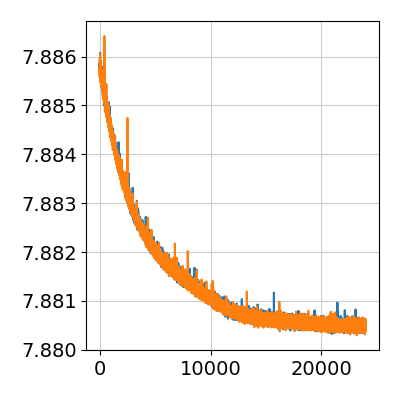

In [12]:
from IPython.display import Image
Image(filename=results_folder+r['run_name']+'/plots/training_history_without_first_20perc.png',
      width=400)

We also need to evaluate the reconstruction accuracy: how well reference regulatory programmes signatures explain spatial data by comparing expected value of the model (Negative Binomial mean) to observed count of each gene across locations. The ideal case is a perfect diagonal 2D histogram plot (every point is a combination of genes and locations). 

A very fuzzy diagonal or large deviations of some genes and locations from the diagonal plot indicate that the reference signatures are incomplete. The reference could be missing certain cell types entirely (e.g. FACS-sorting one cell lineage) or clustering could lack enough granularity (e.g. mapping 5 broad cell types).

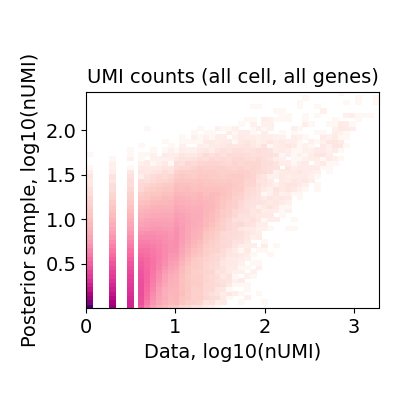

In [13]:
Image(filename=results_folder+r['run_name']+'/plots/data_vs_posterior_mean.png',
      width=400)

Finally, we need to evaluate robustness of the identified locations by comparing consistency of inferred locations between two independent training restarts (X- and Y-axis). The plot below shows the correlation (color) between cell abundance profiles in 2 training restarts. Some cell types can be correlated their abundance patterns but excessive deviations from diagonal would indicate instability of the solution (not seen so far).

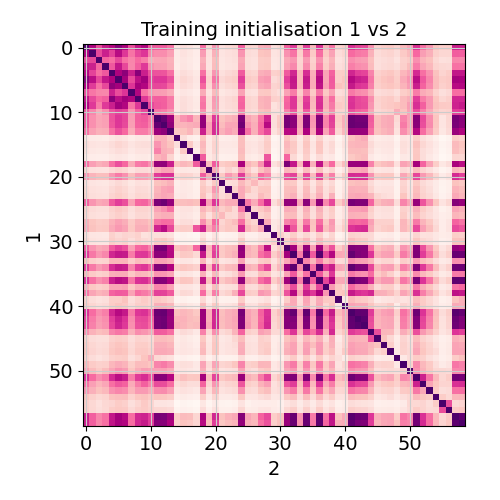

In [14]:
Image(filename=results_folder+r['run_name']+'/plots/evaluate_stability.png',
      width=400)

### Fig 2H <a class="anchor" id="Fig2H"></a> 

#### Read cell2location output maps

In [15]:
sp_data_file = results_folder+r['run_name']+'/sp.h5ad'
adata_vis = anndata.read(sp_data_file)

In [16]:
adata_vis.uns['spatial'] = {k: None for k in adata_vis.obs['filename'].unique()}

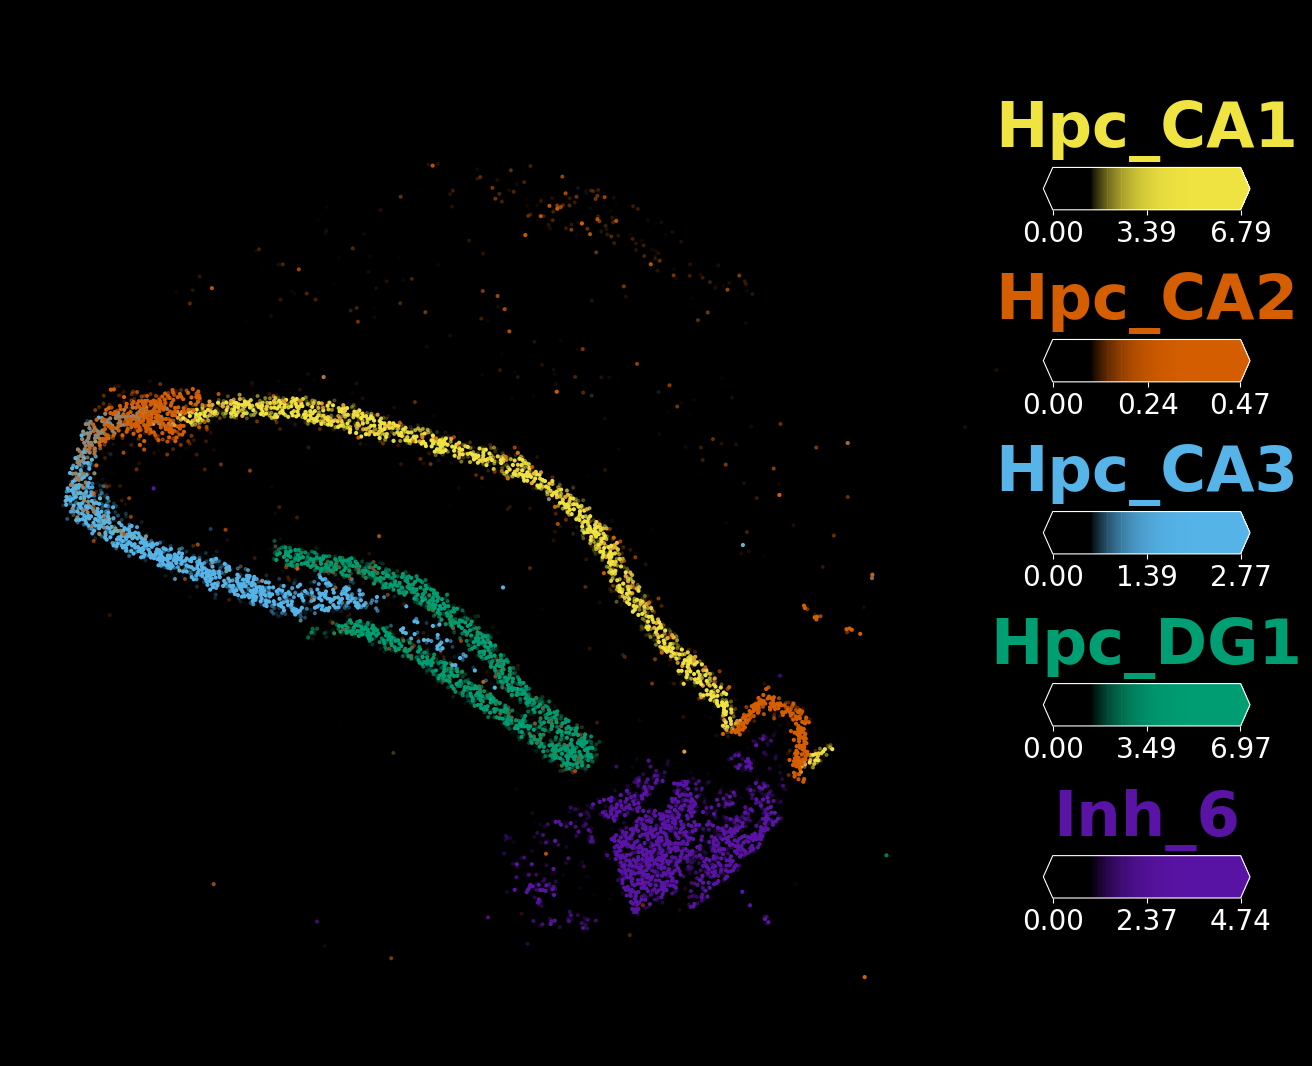

In [17]:
from cell2location.plt.mapping_video import plot_spatial
save_path = f'{results_folder}{r["run_name"]}/plots/figures/'

slide = adata_vis

# select up to 6 clusters 
sel_clust = ['Ext_Hpc_CA1', 'Ext_Hpc_CA2', 'Ext_Hpc_CA3', 'Ext_Hpc_DG1', 'Inh_6']
sel_clust_lab = ['Hpc_CA1', 'Hpc_CA2', 'Hpc_CA3', 'Hpc_DG1', 'Inh_6']
sel_clust_col = ['q05_spot_factors' + str(i) for i in sel_clust]

#crop_x, crop_y = get_crop_coord(slide)

matplotlib.rc_file_defaults()
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
with matplotlib.rc_context({"figure.figsize": (16,16)}):

    fig = plot_spatial(slide.obs[sel_clust_col], 
                  coords=slide.obsm['spatial'], 
                  show_img=False, img_alpha=1,
                  max_color_quantile=0.99, #reorder_cmap=[0,4],
              #img=list(slide.uns['spatial'].values())[0]['images']['hires'],
                  circle_diameter=2, alpha_scaling=1, labels=sel_clust_lab, 
                 style='dark_background', # fast dark_background
              #crop_x=crop_x, crop_y=crop_y,
                       colorbar_position='right',
                     colorbar_label_kw={'size': 45, 'weight': 'bold', 'y': 1.29},
                     colorbar_shape={'vertical_gaps': 2, 'horizontal_gaps': 0, 
                                     'width': 0.2, 'height': 0.35},
                     colorbar_tick_size=20,
                )
    fig.savefig(f'{save_path}Fig2H_HPC_multicell_maps.pdf',
                bbox_inches='tight', facecolor='black')

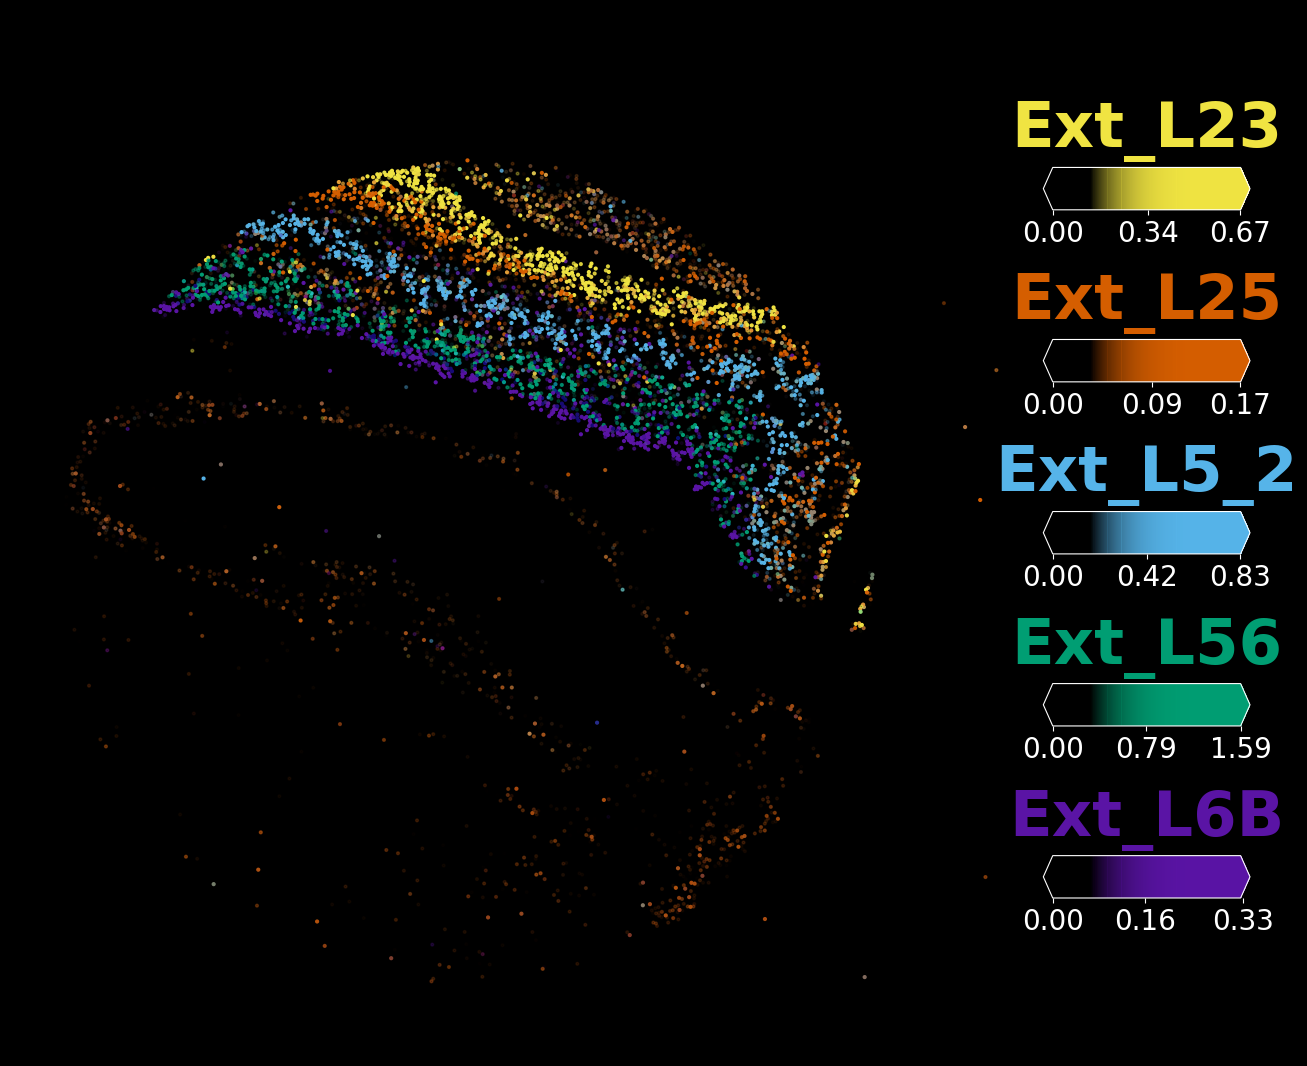

In [18]:
from cell2location.plt.mapping_video import plot_spatial

slide = adata_vis

# select up to 6 clusters 
sel_clust = ['Ext_L23', 'Ext_L25', 'Ext_L5_2', 'Ext_L56', 'Ext_L6B']
sel_clust_col = ['q05_spot_factors' + str(i) for i in sel_clust]

#crop_x, crop_y = get_crop_coord(slide)

matplotlib.rc_file_defaults()
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
with matplotlib.rc_context({"figure.figsize": (16,16)}):

    fig = plot_spatial(slide.obs[sel_clust_col], 
                  coords=slide.obsm['spatial'], 
                  show_img=False, img_alpha=1,
                  max_color_quantile=0.99, #reorder_cmap=[0,4],
              #img=list(slide.uns['spatial'].values())[0]['images']['hires'],
                  circle_diameter=2, alpha_scaling=1, labels=sel_clust, 
                 style='dark_background', # fast dark_background
              #crop_x=crop_x, crop_y=crop_y,
                       colorbar_position='right',
                     colorbar_label_kw={'size': 45, 'weight': 'bold', 'y': 1.29},
                     colorbar_shape={'vertical_gaps': 2, 'horizontal_gaps': 0, 
                                     'width': 0.2, 'height': 0.35},
                     colorbar_tick_size=20,
                )
    fig.savefig(f'{save_path}Fig2H_Ext_L_multicell_maps.pdf',
                bbox_inches='tight', facecolor='black')

### Fig 2H Supplementary Inh neurones <a class="anchor" id="Fig2H_suppl"></a> 

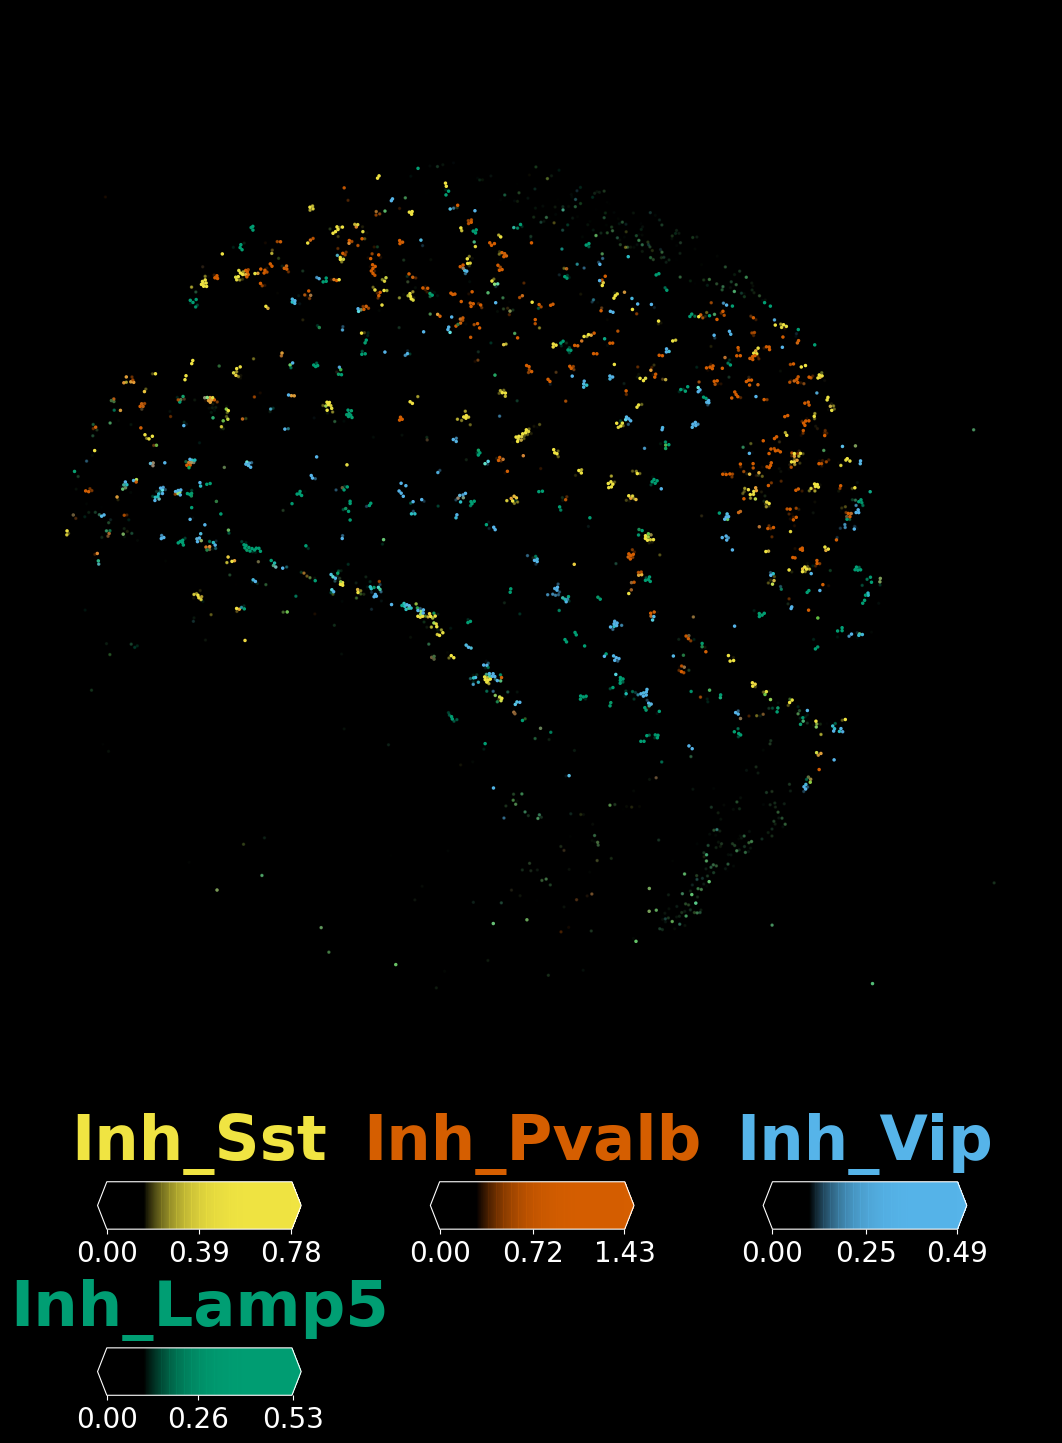

In [19]:
from cell2location.plt.mapping_video import plot_spatial

slide = adata_vis

# select up to 6 clusters 
sel_clust = ['Inh_Sst', 'Inh_Pvalb', 'Inh_Vip', 'Inh_Lamp5']
sel_clust_col = ['q05_spot_factors' + str(i) for i in sel_clust]

#crop_x, crop_y = get_crop_coord(slide)

matplotlib.rc_file_defaults()
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
with matplotlib.rc_context({"figure.figsize": (15,18)}):

    fig = plot_spatial(slide.obs[sel_clust_col], 
                  coords=slide.obsm['spatial'], 
                  show_img=False, img_alpha=1,
                  max_color_quantile=0.995, #reorder_cmap=[0,4],
              #img=list(slide.uns['spatial'].values())[0]['images']['hires'],
                  circle_diameter=1.5, alpha_scaling=1, labels=sel_clust, 
                 style='dark_background', # fast dark_background
              #crop_x=crop_x, crop_y=crop_y,
                 colorbar_label_kw={'size': 45, 'weight': 'bold', 'y': 1.29},
                 colorbar_shape={'vertical_gaps': 0.31, 'horizontal_gaps': 1, 
                                 'width': 3.5, 'height': 0.045},
                 colorbar_tick_size=20,
                )
    fig.savefig(f'{save_path}Fig2H_Inh_multicell_maps.pdf',
                bbox_inches='tight', facecolor='black')

### Fig 3C slide seq supplementary <a class="anchor" id="Fig3C"></a> 

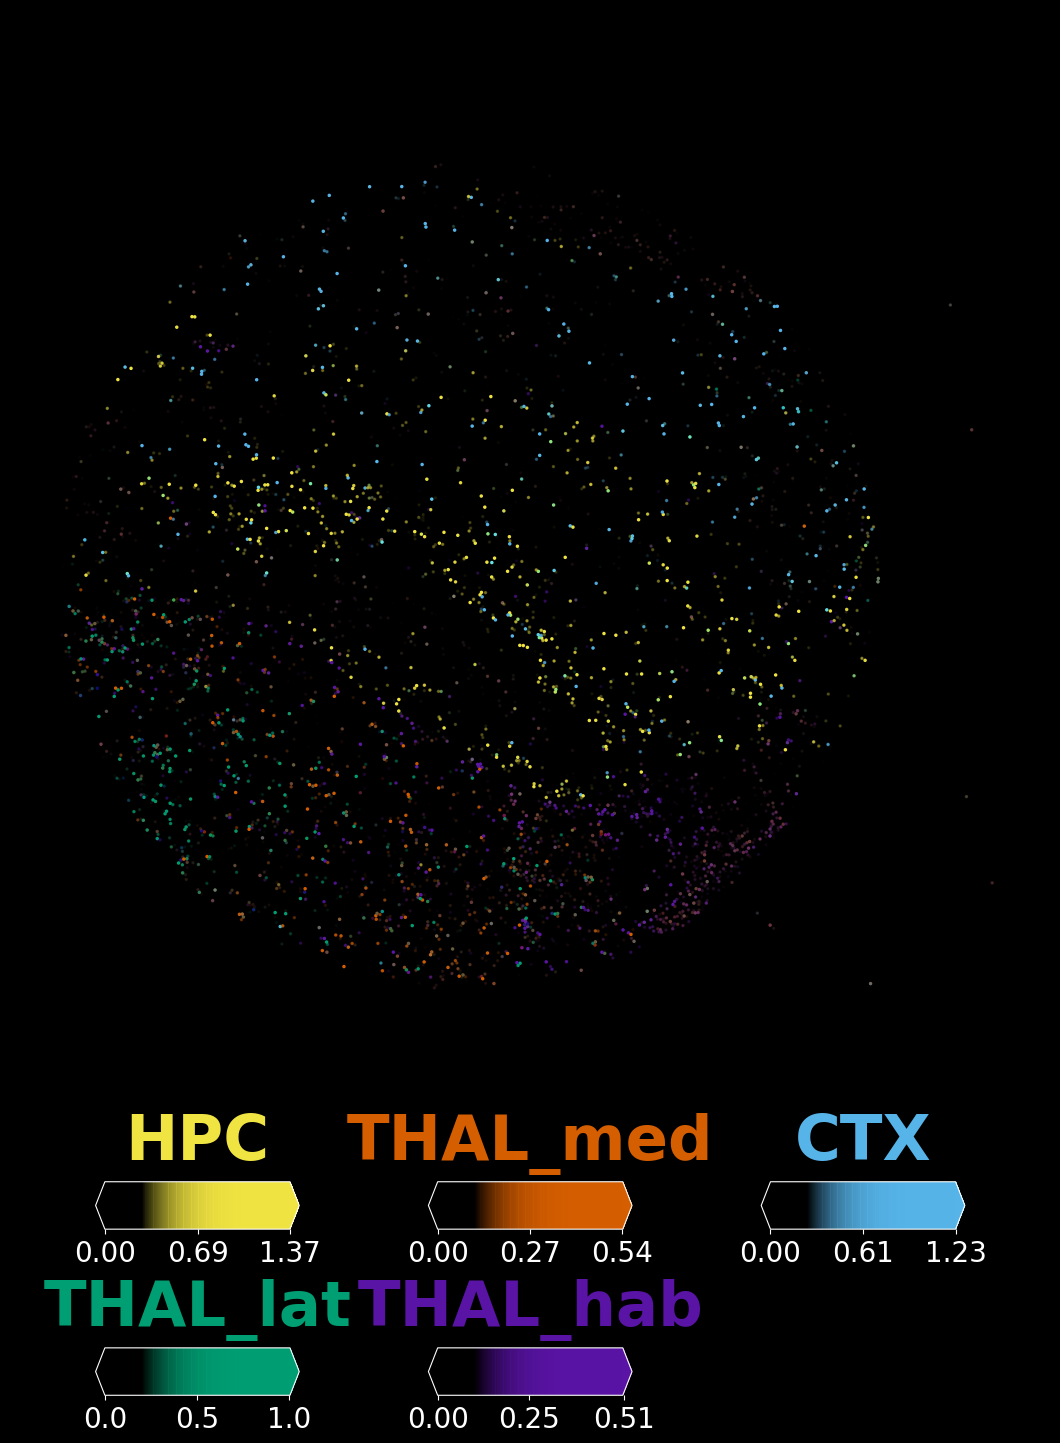

In [20]:
from cell2location.plt.mapping_video import plot_spatial

slide = adata_vis

# select up to 6 clusters 
sel_clust = ['Astro_HPC','Astro_THAL_med','Astro_CTX','Astro_THAL_lat', 'Astro_THAL_hab']
sel_clust_lab = ['HPC','THAL_med','CTX','THAL_lat', 'THAL_hab']
sel_clust_col = ['q05_spot_factors' + str(i) for i in sel_clust]

#crop_x, crop_y = get_crop_coord(slide)

matplotlib.rc_file_defaults()
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
with matplotlib.rc_context({"figure.figsize": (15,18)}):

    fig = plot_spatial(slide.obs[sel_clust_col], 
                  coords=slide.obsm['spatial'], 
                  show_img=False, img_alpha=1,
                  max_color_quantile=0.997, #reorder_cmap=[0,4],
              #img=list(slide.uns['spatial'].values())[0]['images']['hires'],
                  circle_diameter=1.5, alpha_scaling=1, labels=sel_clust_lab, 
                 style='dark_background', # fast dark_background
              #crop_x=crop_x, crop_y=crop_y,
                 colorbar_label_kw={'size': 45, 'weight': 'bold', 'y': 1.29},
                 colorbar_shape={'vertical_gaps': 0.31, 'horizontal_gaps': 1, 
                                 'width': 3.5, 'height': 0.045},
                 colorbar_tick_size=20,
                )
    fig.savefig(f'{save_path}Fig2H_Astro_multicell_maps.pdf',
                bbox_inches='tight', facecolor='black')

Modules and their versions used for this analysis

In [21]:
import sys
for module in sys.modules:
    try:
        print(module,sys.modules[module].__version__)
    except:
        try:
            if  type(sys.modules[module].version) is str:
                print(module,sys.modules[module].version)
            else:
                print(module,sys.modules[module].version())
        except:
            try:
                print(module,sys.modules[module].VERSION)
            except:
                pass

sys 3.7.6 | packaged by conda-forge | (default, Jun  1 2020, 18:57:50) 
[GCC 7.5.0]
ipykernel 5.3.0
ipykernel._version 5.3.0
json 2.0.9
re 2.2.1
IPython 7.15.0
IPython.core.release 7.15.0
logging 0.5.1.2
zlib 1.0
traitlets 4.3.3
six 1.15.0
ipython_genutils 0.2.0
ipython_genutils._version 0.2.0
platform 1.0.8
traitlets._version 4.3.3
decorator 4.4.2
argparse 1.1
IPython.core.crashhandler 7.15.0
pygments 2.6.1
pexpect 4.8.0
ptyprocess 0.6.0
pickleshare 0.7.5
backcall 0.2.0
sqlite3 2.6.0
sqlite3.dbapi2 2.6.0
_sqlite3 2.6.0
prompt_toolkit 3.0.5
wcwidth 0.2.5
jedi 0.17.1
parso 0.7.0
urllib.request 3.7
jupyter_client 6.1.3
jupyter_client._version 6.1.3
zmq 19.0.1
ctypes 1.1.0
_ctypes 1.1.0
zmq.backend.cython 40302
zmq.backend.cython.constants 40302
zmq.sugar 19.0.1
zmq.sugar.constants 40302
zmq.sugar.version 19.0.1
jupyter_core 4.6.3
jupyter_core.version 4.6.3
distutils 3.7.6
tornado 6.0.4
_curses b'2.2'
dateutil 2.8.1
dateutil._version 2.8.1
decimal 1.70
_decimal 1.70
scanpy 1.6.0
numpy 1.1

In [22]:
! ~/gdrive upload --parent 1DevF7bkGvy9mIpoY1Ai6RDNLQ4jlebwy --recursive /nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/stickels_et_al_2020_slide_seqV2/CoLocationModelNB4V2_59clusters_53208locations_9069genes

Creating directory CoLocationModelNB4V2_59clusters_53208locations_9069genes
Uploading /nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/stickels_et_al_2020_slide_seqV2/CoLocationModelNB4V2_59clusters_53208locations_9069genes/model_.p
Uploading /nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/stickels_et_al_2020_slide_seqV2/CoLocationModelNB4V2_59clusters_53208locations_9069genes/W_mRNA_count.csv
Creating directory plots                          
Creating directory figures
Uploading /nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/stickels_et_al_2020_slide_seqV2/CoLocationModelNB4V2_59clusters_53208locations_9069genes/plots/figures/Fig2H_Inh_multicell_maps.pdf
Creating directory .ipynb_checkpoints
Uploading /nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/stickels_et_al_2020_slide_seqV2/CoLocationModelNB4V2_59clusters_53208locations_9069genes/plots/figures/Fig2H_Ext